In [1]:
import pandas
import datetime
import math
import os
import numpy
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
# setup some params
testDate = datetime.datetime( 2011, 3, 2, 2, 2, 30 )
# only choose the North American sector for analysis
glonRngNA = [ -165., -60. ]
binSize = 5.
binCutoff = 0.5
segLgthCutoff = 10.

In [3]:
fltdTrghLocFname = "../data/test-fltrdTrghLoc.txt"
fltTecDataDF = pandas.read_csv(fltdTrghLocFname, sep=' ',\
                            parse_dates=["date"],\
                               infer_datetime_format=True)
fltTecDataDF.head()

,BndEquGlat,BndEquMlat,BndEquMlon,BndEquTecVal,BndGlon,BndPolGlat,BndPolMlat,BndPolMlon,BndPolTecVal,date,minFltrdTecVal,minTecGlat,minTecMlat,minTecMlon,minTecVal
0,38.0,47.634053,-37.976848,4.3,-105.0,44.0,53.490621,-38.841781,5.35,2011-02-05 02:32:30,3.881276,40.0,49.582218,-38.251632,3.4
1,38.0,47.794316,-36.738952,4.2,-104.0,44.0,53.643162,-37.552536,5.10,2011-02-05 02:32:30,3.730546,40.0,49.739906,-36.996803,3.4
2,38.0,47.950059,-35.489789,4.5,-103.0,44.0,53.790550,-36.251329,4.70,2011-02-05 02:32:30,3.939476,41.0,50.866049,-35.855276,3.7
3,43.0,54.150050,-15.556051,6.5,-88.0,50.0,60.836759,-15.643711,5.00,2011-02-05 02:32:30,4.273354,47.0,57.972376,-15.584212,3.9
4,42.0,53.210803,-14.144962,6.9,-87.0,51.0,61.798285,-14.180143,6.40,2011-02-05 02:32:30,4.862104,46.0,57.027693,-14.126782,4.4


In [4]:

selTrDF = fltTecDataDF[ (fltTecDataDF["date"] == testDate) & \
                       (fltTecDataDF["BndGlon"] >= glonRngNA[0]) &\
                      (fltTecDataDF["BndGlon"] <= glonRngNA[1]) ].reset_index(drop=True)
selTrDF.head()

,BndEquGlat,BndEquMlat,BndEquMlon,BndEquTecVal,BndGlon,BndPolGlat,BndPolMlat,BndPolMlon,BndPolTecVal,date,minFltrdTecVal,minTecGlat,minTecMlat,minTecMlon,minTecVal
0,44.0,55.119523,-12.700280,6.7,-86.0,57.0,67.455857,-12.829833,6.20,2011-03-02 02:02:30,2.462761,48.0,58.938937,-12.673222,1.00
1,44.0,55.111065,-11.270429,6.7,-85.0,57.0,67.447539,-11.268012,6.20,2011-03-02 02:02:30,2.582391,48.0,58.929376,-11.209919,1.20
2,43.0,54.110099,-8.450846,7.5,-83.0,50.0,60.788383,-8.240582,3.70,2011-03-02 02:02:30,2.752367,48.0,58.880311,-8.288618,1.85
3,43.0,54.019424,-5.618372,7.0,-81.0,52.0,62.607023,-5.222742,1.45,2011-03-02 02:02:30,1.999888,49.0,59.747096,-5.338945,1.60
4,43.0,53.958363,-4.207771,7.0,-80.0,54.0,64.450506,-3.650925,5.95,2011-03-02 02:02:30,2.125773,49.0,59.688923,-3.884564,1.50


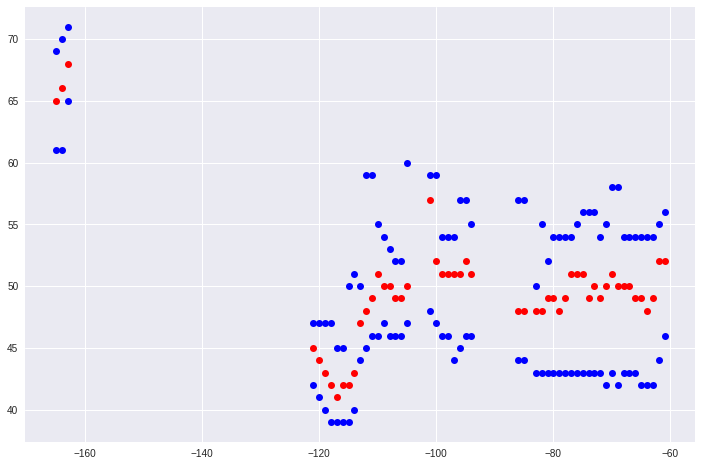

In [5]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.plot( selTrDF["BndGlon"], selTrDF["BndEquGlat"], "bo" )
ax.plot( selTrDF["BndGlon"], selTrDF["minTecGlat"], "ro" )
ax.plot( selTrDF["BndGlon"], selTrDF["BndPolGlat"], "bo" )
# ax.plot( BndEquMlonArr, BndEquMlatArr, "bo" )
# ax.plot( minTecMlonArr, minTecMlatArr, "ro" )
# ax.plot( BndPolMlonArr, BndPolMlatArr, "bo" )
# f.savefig("../figs/bndry-" + nrstTime.strftime("%Y%m%d-%H%M") + ".pdf",bbox_inches='tight')

In [6]:
sortedGlonArr = numpy.sort( selTrDF["BndGlon"] )
print sortedGlonArr
# print numpy.diff( sortedGlonArr )
# Identify sudden and big jumps in Long
# We'll identify jumps by using the gradient
# Function!
glonGradInds = numpy.where( numpy.diff( sortedGlonArr ) > 5. )
# print sortedGlonArr[glonGradInds], glonGradInds[-1], len(sortedGlonArr)
# Need to get the length of the segments
segLgnthArr = []
currStrtElmnt = 0
for ele in glonGradInds[-1]:
    segLgnthArr.append( ele - currStrtElmnt )
    currStrtElmnt = ele
segLgnthArr.append( len(sortedGlonArr) - currStrtElmnt )
print segLgnthArr
print glonGradInds

[-165. -164. -163. -121. -120. -119. -118. -117. -116. -115. -114. -113.
 -112. -111. -110. -109. -108. -107. -106. -105. -101. -100.  -99.  -98.
  -97.  -96.  -95.  -94.  -86.  -85.  -83.  -82.  -81.  -80.  -79.  -78.
  -77.  -76.  -75.  -74.  -73.  -72.  -71.  -70.  -69.  -68.  -67.  -66.
  -65.  -64.  -63.  -62.  -61.]
[2, 25, 26]
(array([ 2, 27]),)


In [7]:
prevSegInd = 0 
finTrghGlons = numpy.array( [] )
for currSegLen in segLgnthArr:
    if prevSegInd == 0 :
        strtElementInd = prevSegInd
    else:
        strtElementInd = prevSegInd + 1
    endElementInd = prevSegInd + currSegLen
    if endElementInd == len(sortedGlonArr):
        endElementInd -= 1
    if currSegLen >= segLgthCutoff:
        segIndsSel = [ prevSegInd , prevSegInd + currSegLen ]
        finTrghGlons = numpy.append( finTrghGlons, sortedGlonArr[strtElementInd:endElementInd+1] )
    prevSegInd = prevSegInd + currSegLen

# Only include the glons that are selected
selTrDF = selTrDF[ selTrDF["BndGlon"].isin( finTrghGlons )\
                 ].reset_index(drop=True)
# Now discard TEC values which are 2 stds away!!!!
selTrDF = selTrDF[ \
            selTrDF["minFltrdTecVal"] <= \
            ( selTrDF["minFltrdTecVal"].mean()\
             + 2 * selTrDF["minFltrdTecVal"].std() ) ]

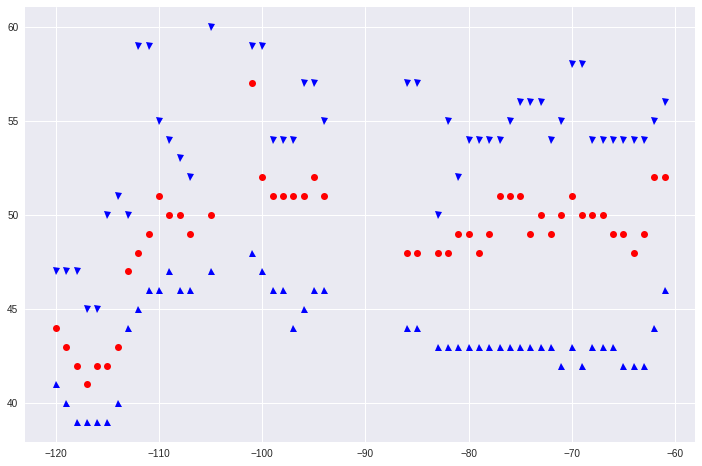

In [8]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.plot( selTrDF["BndGlon"], selTrDF["BndEquGlat"], "b^" )
ax.plot( selTrDF["BndGlon"], selTrDF["minTecGlat"], "ro" )
ax.plot( selTrDF["BndGlon"], selTrDF["BndPolGlat"], "bv" )
# ax.plot( BndEquMlonArr, BndEquMlatArr, "bo" )
# ax.plot( minTecMlonArr, minTecMlatArr, "ro" )
# ax.plot( BndPolMlonArr, BndPolMlatArr, "bo" )
# f.savefig("../figs/bndry-" + nrstTime.strftime("%Y%m%d-%H%M") + ".pdf",bbox_inches='tight')